In [19]:
import jax
import jax.numpy as jnp
import ott
from ott.geometry import pointcloud
from ott.solvers import linear
import ott.geometry.costs as costs

We first implement the projection Algorithm 2 in original paper, whose purpose is to take an arbitrary matrix **$\pi$** and force it to become a **valid transport plan** that matches the given marginal distributions **$p$** and **$q$**.

In [20]:
import jax.numpy as jnp


def proj_corrected(p: jnp.ndarray, q: jnp.ndarray, pi: jnp.ndarray):
    """
    Correctly implements the projection from Algorithm 2.

    Args:
        p (jnp.ndarray): (n,), source probability vector.
        q (jnp.ndarray): (m,), target probability vector.
        pi (jnp.ndarray): (n, m), transport plan matrix.
    
    Returns:
        projected (jnp.ndarray): (n, m), the projected transport plan.
    """
    a = jnp.minimum(1.0, p / pi.sum(axis=1))
    pi_prime = a[:, None] * pi

    b = jnp.minimum(1.0, q / pi_prime.sum(axis=0))
    pi_prime_prime = pi_prime * b[None, :]

    diff_p = p - pi_prime_prime.sum(axis=1)
    diff_q = q - pi_prime_prime.sum(axis=0)

    denominator = diff_p.sum()
    # Avoid division by zero if diff_p is all zeros.
    correction = jnp.where(denominator == 0, 0,
                           jnp.outer(diff_p, diff_q) / denominator)

    return pi_prime_prime + correction

## Unstructured Random Cost

In [21]:
from jax import Array
from jax.numpy import ndarray
import jax.tree_util as jtu


@jtu.register_pytree_node_class
class Random(costs.SqEuclidean):
    """Random distance.
    """

    def all_pairs(self, x: Array, y: Array) -> Array:
        random_cost = jax.random.normal(key=jax.random.key(0),
                                        shape=(x.shape[0], y.shape[0]))
        random_cost /= (random_cost.max() - random_cost.min())
        return random_cost


Define the point clouds and probability vectors of the random case. We use a very small $\epsilon$ to approximate the ground truth optimal transport plan

In [ ]:
m, n = 75, 75
p, q = jax.random.uniform(
    jax.random.key(0),
    (m, ),
), jax.random.uniform(
    jax.random.key(1),
    (n, ),
)
p /= p.sum()
q /= q.sum()
x, y = jax.random.uniform(
    jax.random.key(0),
    (m, 2),
), jax.random.uniform(
    jax.random.key(0),
    (n, 2),
),
geom = pointcloud.PointCloud(x, y, cost_fn=Random(), epsilon=1e-4)
solve_fn = jax.jit(linear.solve)

print(q.shape)


(75,)


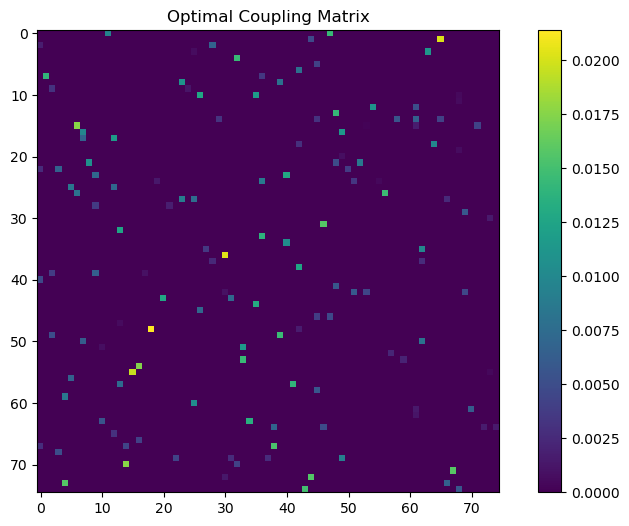

In [26]:
from matplotlib import pyplot as plt

ot = solve_fn(geom, p, q)
plt.figure(figsize=(10, 6))
plt.imshow(ot.matrix)
plt.colorbar()
plt.title("Optimal Coupling Matrix")
plt.show()

Next, we are going to calculate and plot $\langle c,\text{proj}_{\Gamma(p,q)}(\pi_t)-\text{OT}(p,q)\rangle$. The reason why we use $\langle c,\text{proj}_{\Gamma(p,q)}(\pi_t)\rangle$ instead of simpler $\langle c,\pi_t \rangle$ is that the Annealed Sinkhorn introduces **Relaxation error**, saying that $\left\| \pi_t \mathbb{1} - p \right\|_1$

In [34]:
## The implementation is hacky as we need to track the intermediate $\pi_t$, otherwise we can directly use schedule
from typing import Callable
import numpy as np
from ott.solvers.linear import acceleration
from ott.initializers.linear import initializers as init_lib

states_history = []


def store_state_callback(args: tuple):
    """A callback function to store the SinkhornState."""
    iteration, _, _, state = args
    # We append the potentials to our external list.
    # We use np.asarray to copy the data from the device to the host CPU.
    states_history.append(
        (iteration, jax.tree_util.tree_map(np.asarray, state.potentials)))


track_solve = jax.jit(linear.solve, static_argnames=["progress_fn"])
ot = track_solve(geom, p, q, progress_fn=store_state_callback)
print(ot.converged)

False


In [33]:
print(len(states_history))

2000
